In [1]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

In [2]:
def get_two_colormaps(k, avoid_white=True):
    """
    Returns two lists of k colors each:
    - One from the 'Blues' colormap
    - One from the 'Reds' colormap
    Colors are spaced and trimmed to avoid white and black extremes.
    """
    # Trim range to avoid white (too light) and near-black (too dark)
    min_val, max_val = (0.3, 0.85) if avoid_white else (0.0, 1.0)
    sample_points = np.linspace(min_val, max_val, k)

    blues_cmap = plt.cm.Blues(sample_points)
    reds_cmap = plt.cm.Reds(sample_points)

    # Convert to RGB tuples (remove alpha)
    blues_rgb = [tuple(color[:3]) for color in blues_cmap]
    reds_rgb = [tuple(color[:3]) for color in reds_cmap]

    return blues_rgb, reds_rgb# def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
#     """
#     Estimate amplitude by detecting peaks and computing average peak height.

#     Parameters:
#     - signal: 1D numpy array
#     - height, distance, prominence: Optional arguments for peak detection

#     Returns:
#     - amplitude: Estimated amplitude
#     - peak_values: Values of detected peaks
#     - trough_values: Values of detected troughs
#     """
#     peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
#     troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

#     peak_values = signal[peaks]
#     trough_values = signal[troughs]

#     if len(peak_values) == 0 or len(trough_values) == 0:
#         return None, peak_values, trough_values  # Not enough data

#     avg_peak = np.mean(peak_values)
#     avg_trough = np.mean(trough_values)
 
#     amplitude = 0.5 * (avg_peak - avg_trough)
#     amplitude = np.nan_to_num(amplitude, nan=0.0)  # Handle NaN values
#     return amplitude, peak_values, trough_values

def estimate_amplitude_from_peaks(signal, height=None, distance=5000, prominence=None):
    """
    Estimate the amplitude of an oscillating signal using peak and trough detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, automatically ignore first peak/trough if it's a large outlier

    Returns:
    - amplitude: Estimated average amplitude (float)
    - peak_indices: Indices of the used peaks
    - trough_indices: Indices of the used troughs
    """
    peak_indices, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    trough_indices, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    if len(peak_indices) < 1 or len(trough_indices) < 1:
        return None, peak_indices, trough_indices

    peak_vals = signal[peak_indices]
    trough_vals = signal[trough_indices]

    min_len = min(len(peak_vals), len(trough_vals))
    if min_len < 1:
        return None, peak_indices, trough_indices

    amplitude = 0.5 * np.mean(peak_vals[:min_len] - trough_vals[:min_len])

    return amplitude, peak_indices[:min_len], trough_indices[:min_len]



# def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
#     """
#     Estimate the period of an oscillating signal using peak detection.

#     Parameters:
#     - signal: 1D numpy array of the signal values
#     - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
#     - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

#     Returns:
#     - period: Estimated average period (float)
#     - peak_times: Time values of the detected peaks
#     """
#     # Find peaks
#     peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
#     if time is None:
#         # Assume uniform spacing
#         time = np.arange(len(signal))

#     peak_times = time[peaks]

#     if len(peak_times) < 4:
#         period = 0  # Not enough peaks to estimate period

#     # Calculate differences between consecutive peaks
#     peak_diffs = np.diff(peak_times)
#     period = np.mean(peak_diffs)

#     return period, peak_times

def estimate_period_from_peaks(signal, time=None, height=None, distance=500, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks
    - ignore_initial_outlier: If True, ignores the first peak if it's a large outlier

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)

    if len(peaks) < 2:
        return None, np.array([])  # Not enough peaks to estimate period

    # Optionally remove initial outlier peak
    peak_vals = signal[peaks]

    # Assume uniform spacing if time is not given
    if time is None:
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 2:
        return None, peak_times  # Still not enough peaks

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

def analysis_2cells(results, time_settled, variable1, variable2):
    #for results a 2D array of shape (variable1, variable2, num_tsteps, num_cells, 2)
    dt = 0.2
    h0 = results[:,:,  time_settled:, 0, 0]
    h1 = results[:,:,  time_settled:, 0, 1]
    d0 = results[:,:,  time_settled:, 1, 0]
    d1 = results[:,:,  time_settled:, 1, 1]

    # calculate the difference between the two cells 
    h_diff = np.abs(h0 - h1)
    d_diff = np.abs(d0 - d1)

    
    h0_LI_mean = np.zeros((len(variable1), len(variable2)))
    h1_LI_mean = np.zeros((len(variable1), len(variable2)))
    d0_LI_mean = np.zeros((len(variable1), len(variable2)))
    d1_LI_mean = np.zeros((len(variable1), len(variable2)))


    # setting empty arrays for the results
    h_diff_LI_mean = np.zeros((len(variable1), len(variable2)))
    d_diff_LI_mean = np.zeros((len(variable1), len(variable2)))

    first_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)
    last_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)

    period_synced_h0 = np.zeros((len(variable1), len(variable2)))
    period_synced_h1 = np.zeros((len(variable1), len(variable2)))
    period_synced_d0 = np.zeros((len(variable1), len(variable2)))
    period_synced_d1 = np.zeros((len(variable1), len(variable2)))

    period_LI_h0 = np.zeros((len(variable1), len(variable2)))
    period_LI_h1 = np.zeros((len(variable1), len(variable2)))
    period_LI_d0 = np.zeros((len(variable1), len(variable2)))
    period_LI_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_synced_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_h1 = np.zeros((len(variable1), len(variable2)))    
    amplitude_synced_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_LI_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_LI_h1 = np.zeros((len(variable1), len(variable2)))
    amplitude_LI_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_LI_d1 = np.zeros((len(variable1), len(variable2)))

    # point of lateral inhibition
    for i in range(len(variable1)):
        for j in range(len(variable2)):

            if np.any(d_diff[i,j] < 0.5):
            # Find the first index where d_diff is very small 
                zero_indices = np.where(d_diff[i,j] < 0.5)[0]
                first_zero_index[i,j] = zero_indices[0]
                last_zero_index[i,j] = zero_indices[-1] + 1

                h0_synced = h0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                h1_synced = h1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d0_synced = d0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d1_synced = d1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]

                period_synced_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(-h0_synced, time = np.arange(len(h0_synced))*dt)[0], nan=0.0)
                period_synced_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(-h1_synced, time = np.arange(len(h1_synced))*dt)[0], nan=0.0)
                period_synced_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(-d0_synced, time = np.arange(len(d0_synced))*dt)[0], nan=0.0)
                period_synced_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(-d1_synced, time = np.arange(len(d1_synced))*dt)[0], nan=0.0)

                amplitude_synced_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0_synced)[0], nan=0.0)
                amplitude_synced_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1_synced)[0], nan=0.0)
                amplitude_synced_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0_synced)[0], nan=0.0)
                amplitude_synced_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1_synced)[0], nan=0.0)

            if last_zero_index[i,j] < results.shape[2]:
                tsteps_LI = results.shape[2] - last_zero_index[i,j]
                period_LI_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(-h0[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)
                period_LI_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(-h1[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)
                period_LI_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(-d0[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)
                period_LI_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(-d1[i,j, last_zero_index[i,j]:], time = np.arange(tsteps_LI)*dt)[0], nan=0.0)

                amplitude_LI_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0[i,j, last_zero_index[i,j]:])[0], nan=0.0)
                amplitude_LI_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1[i,j, last_zero_index[i,j]:])[0], nan=0.0)
                amplitude_LI_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0[i,j, last_zero_index[i,j]:])[0], nan=0.0)
                amplitude_LI_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1[i,j, last_zero_index[i,j]:])[0], nan=0.0)

                h_diff_LI_mean[i,j] = np.mean(h_diff[i,j, last_zero_index[i,j]:])
                d_diff_LI_mean[i,j] = np.mean(d_diff[i,j, last_zero_index[i,j]:])

                h0_LI_mean[i,j] = np.mean(h0[i,j, last_zero_index[i,j]:])
                h1_LI_mean[i,j] = np.mean(h1[i,j, last_zero_index[i,j]:])
                d0_LI_mean[i,j] = np.mean(d0[i,j, last_zero_index[i,j]:])
                d1_LI_mean[i,j] = np.mean(d1[i,j, last_zero_index[i,j]:])
  
    result_diff = [h_diff, d_diff]
    result_diff_LI_mean = [h_diff_LI_mean, d_diff_LI_mean]
    result_LI_mean = [h0_LI_mean, h1_LI_mean, d0_LI_mean, d1_LI_mean]
    result_synced_index = [first_zero_index, last_zero_index]

    result_period_synced = [period_synced_h0, period_synced_h1, period_synced_d0, period_synced_d1]
    result_period_LI = [period_LI_h0, period_LI_h1, period_LI_d0, period_LI_d1]

    result_amplitude_synced = [amplitude_synced_h0, amplitude_synced_h1, amplitude_synced_d0, amplitude_synced_d1]
    result_amplitude_LI = [amplitude_LI_h0, amplitude_LI_h1, amplitude_LI_d0, amplitude_LI_d1]

    return result_diff, result_diff_LI_mean, result_LI_mean, result_synced_index, result_period_synced, result_amplitude_synced, result_period_LI, result_amplitude_LI

def analysis_2cells_checkerboard(results, time_settled, variable1, variable2):
    #for results a 2D array of shape (variable1, variable2, num_tsteps, num_cells, 2)
    dt = 0.2
    h0 = results[:,:,  time_settled:, 0, 0]
    h1 = results[:,:,  time_settled:, 0, 1]
    d0 = results[:,:,  time_settled:, 1, 0]
    d1 = results[:,:,  time_settled:, 1, 1]

    # calculate the difference between the two cells 
    h_diff = np.abs(h0 - h1)
    d_diff = np.abs(d0 - d1)

    period_h0 = np.zeros((len(variable1), len(variable2)))
    period_h1 = np.zeros((len(variable1), len(variable2)))
    period_d0 = np.zeros((len(variable1), len(variable2)))
    period_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_h1 = np.zeros((len(variable1), len(variable2)))    
    amplitude_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_d1 = np.zeros((len(variable1), len(variable2)))

    # point of lateral inhibition
    for i in range(len(variable1)):
        for j in range(len(variable2)):
            period_h0[i,j] = np.nan_to_num(estimate_period_from_peaks(-h0[i,j], time = np.arange(len(h0[i,j]))*dt)[0], nan=0.0)
            period_h1[i,j] = np.nan_to_num(estimate_period_from_peaks(-h1[i,j], time = np.arange(len(h1[i,j]))*dt)[0], nan=0.0)
            period_d0[i,j] = np.nan_to_num(estimate_period_from_peaks(-d0[i,j], time = np.arange(len(d0[i,j]))*dt)[0], nan=0.0)
            period_d1[i,j] = np.nan_to_num(estimate_period_from_peaks(-d1[i,j], time = np.arange(len(d1[i,j]))*dt)[0], nan=0.0)

            amplitude_h0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h0[i,j])[0], nan=0.0)
            amplitude_h1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(h1[i,j])[0], nan=0.0)
            amplitude_d0[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d0[i,j])[0], nan=0.0)
            amplitude_d1[i,j] = np.nan_to_num(estimate_amplitude_from_peaks(d1[i,j])[0], nan=0.0)
  
    result_diff = [h_diff, d_diff]

    result_period = [period_h0, period_h1, period_d0, period_d1]

    result_amplitude = [amplitude_h0, amplitude_h1, amplitude_d0, amplitude_d1]


    return result_diff, result_period, result_amplitude

def find_shift(values_d, values_h):
    values_d = np.array(values_d)
    values_h = np.array(values_h)

    closest = np.zeros(len(values_h))
    distances = np.zeros(len(values_h))

    if len(values_d) == 0 or len(values_h) == 0:
        return np.nan
    for k in range(len(values_h)):
        distance = np.abs(values_h[k] - values_d)
        closest[k] = np.argmin(distance)
        distances[k] = np.min(distance)

    unique, counts = np.unique(closest, return_counts=True)
    duplicates = unique[counts > 1]

    # Get the positions (indexes) of duplicates
    duplicate_positions = {val: np.where(closest == val)[0] for val in duplicates}

    # Set others to NaN (or -1 if you prefer an int flag)
    cleaned_closest = closest.astype(float)  # allow NaN
    for dup_val, positions in duplicate_positions.items():
        # Find the one with the smallest distance
        best_idx = positions[np.argmin(distances[positions])]
        # Set others to NaN
        for idx in positions:
            if idx != best_idx:
                cleaned_closest[idx] = np.nan
                distances[idx] = np.nan

    shift = np.nanmean(distances)*dt

    return shift


def analysis_2cells_delay(results, time_settled, variable1, variable2, dt=0.2):
    #for results a 2D array of shape (variable1, variable2, num_tsteps, num_cells, 2)

    h0 = results[:,:,  time_settled:, 0, 0]
    h1 = results[:,:,  time_settled:, 0, 1]
    d0 = results[:,:,  time_settled:, 1, 0]
    d1 = results[:,:,  time_settled:, 1, 1]

    # calculate the difference between the two cells 
    h_diff = np.abs(h0 - h1)
    d_diff = np.abs(d0 - d1)

    first_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)
    last_zero_index = np.zeros((len(variable1), len(variable2)), dtype=int)

    period_synced_h0 = np.zeros((len(variable1), len(variable2)))
    period_synced_h1 = np.zeros((len(variable1), len(variable2)))
    period_synced_d0 = np.zeros((len(variable1), len(variable2)))
    period_synced_d1 = np.zeros((len(variable1), len(variable2)))

    amplitude_synced_h0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_h1 = np.zeros((len(variable1), len(variable2)))    
    amplitude_synced_d0 = np.zeros((len(variable1), len(variable2)))
    amplitude_synced_d1 = np.zeros((len(variable1), len(variable2)))

    shift_peaks = np.zeros((len(variable1), len(variable2)))
    shift_troughs = np.zeros((len(variable1), len(variable2)))

    # point of lateral inhibition
    for i in range(len(variable1)):
        for j in range(len(variable2)):

            if np.any(d_diff[i,j] < 0.5):
            # Find the first index where d_diff is very small 
                zero_indices = np.where(d_diff[i,j] < 0.5)[0]
                first_zero_index[i,j] = zero_indices[0]
                last_zero_index[i,j] = zero_indices[-1] + 1

                h0_synced = h0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                h1_synced = h1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d0_synced = d0[i,j,first_zero_index[i,j]:last_zero_index[i,j]]
                d1_synced = d1[i,j,first_zero_index[i,j]:last_zero_index[i,j]]

                period, h0_peaks = estimate_period_from_peaks(h0_synced, time = np.arange(len(h0_synced))*dt)
                period, d0_peaks = estimate_period_from_peaks(d0_synced, time = np.arange(len(d0_synced))*dt)

                period_synced_h0[i,j], h0_troughs = estimate_period_from_peaks(-h0_synced, time = np.arange(len(h0_synced))*dt)
                period_synced_h1[i,j], _ = estimate_period_from_peaks(-h1_synced, time = np.arange(len(h1_synced))*dt)
                period_synced_d0[i,j], d0_troughs = estimate_period_from_peaks(-d0_synced, time = np.arange(len(d0_synced))*dt)
                period_synced_d1[i,j], _ = estimate_period_from_peaks(-d1_synced, time = np.arange(len(d1_synced))*dt)

                # calculate the time shift between peaks of the two cells
                amplitude_synced_h0[i,j] = estimate_amplitude_from_peaks(h0_synced)[0]
                amplitude_synced_h1[i,j] = estimate_amplitude_from_peaks(h1_synced)[0]
                amplitude_synced_d0[i,j] = estimate_amplitude_from_peaks(d0_synced)[0]
                amplitude_synced_d1[i,j] = estimate_amplitude_from_peaks(d1_synced)[0]

                shift_peaks[i,j] = find_shift(h0_peaks, d0_peaks)
                shift_troughs[i,j] = find_shift(h0_troughs, d0_troughs)
                
  
    result_diff = [h_diff, d_diff]
    result_synced_index = [first_zero_index, last_zero_index]

    result_period_synced = [period_synced_h0, period_synced_h1, period_synced_d0, period_synced_d1]

    result_amplitude_synced = [amplitude_synced_h0, amplitude_synced_h1, amplitude_synced_d0, amplitude_synced_d1]

    result_shift = [shift_peaks, shift_troughs]

    return result_diff, result_synced_index, result_period_synced, result_amplitude_synced, result_shift

In [17]:
# run simulation with right parameters multiple times
def multiple_runs(num_runs, num_tsteps, dt, params, variable):
    """
    Run the simulation multiple times and return the results.
    """

    results = np.zeros((num_runs, len(epsilons), num_tsteps, 2, 2))
    
    for i in tqdm(range(num_runs)):
        for j in range(len(epsilons)):
            params.w_coupling = epsilons[j]
            
            h, m_h, d, d_h = simulate(num_tsteps, dt, lattice, params, coupling_type='Delta', initial_type='uniform')
    
            results[i, j, :, 0, 0] = h[:, 0].flatten()
            results[i, j, :, 0, 1] = h[:, 1].flatten()
            results[i, j, :, 1, 0] = d[:, 0].flatten()
            results[i, j, :, 1, 1] = d[:, 1].flatten()

    return results

#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 0
T_coupling = 0
w_h = 1
w_coupling = 0.02
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

num_tsteps = 20000
dt = 0.2
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
num_runs = 10
time_settled = 2000
results = multiple_runs(num_runs, num_tsteps, dt, params, epsilons)




namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([0., 0.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0.02, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


100%|██████████| 10/10 [10:07<00:00, 60.75s/it]


In [18]:
results = np.reshape(results, (num_runs, 1, len(epsilons), num_tsteps, 2, 2))
for i in range(num_runs):
    result_diff_i, result_diff_LI_mean_i, result_LI_mean_i, result_synced_index_i, result_period_synced_i, result_amplitude_synced_i, result_period_LI_i, result_amplitude_LI_i = analysis_2cells(results[i], time_settled, [1], epsilons)

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_19356\2637116062.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGn')


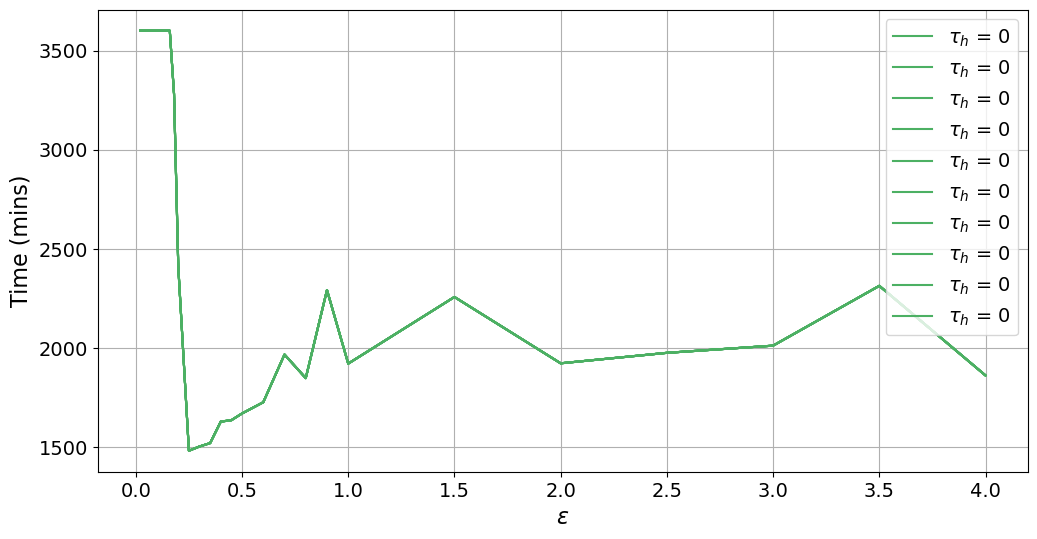

In [19]:
cmap = cm.get_cmap('YlGn') 
colour = cmap(0.6)  # Use a color from the colormap

plt.figure(figsize=(12, 6))
for i in range(num_runs):
    plt.plot(epsilons, result_synced_index_i[1][0,:]*dt, color = colour, label = r'$\tau_h$ = 0' )
plt.xlabel(r'$\varepsilon$', fontsize=16)
plt.ylabel('Time (mins)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)